## Reinterpreting  by patching an existing HistFactory pdf spec

An important pattern in High-Energy physics in the reinterpretation of analyses with respect to new signal models.

The main idea is that a given phase space selection (an "analysis") designed for some original BSM physics signal may not only be efficient for that signal (indeed, likely it was *optimized* for that signal) but also be reasonably efficient for other signals (albeit not optimal). Thus, upon generating the new signal, one can pass the new signal sample through the analysis pipeline to obtain a new estimate of its distribution with the channels defined by the analysis.

The final step is then to construct a new statistical model by swapping out the old for the new signal and evaluate new limits based on this new, modified models.

In `pyhf` this final step is demonstrated here is very easy to perform as demonstrated in this notebook.


First some basic import and plotting code we will use later

In [1]:
import jsonpatch
import pyhf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_results(mutests, tests, test_size = 0.05):
    cls_obs = np.array([test[0] for test in tests]).flatten()
    cls_exp = [np.array([test[1][i] for test in tests]).flatten() for i in range(5)]
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['k','k','k','k','k']):
        plt.plot(mutests, cls_exp[i], c = c, linestyle = 'dotted' if i!=2 else 'dashed')
    plt.fill_between(testmus,cls_exp[0],cls_exp[-1], facecolor = 'y')
    plt.fill_between(testmus,cls_exp[1],cls_exp[-2], facecolor = 'g')
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def invert_interval(testmus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size,
                                             list(reversed(yvals)),
                                             list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,
                                    list(reversed(yvals)),
                                    list(reversed(testmus)))
    return point05cross

### The originial statistical Model

In [3]:
data = [51, 62.]
original = pyhf.simplemodels.hepdata_like(
    signal_data =[5.,6.],
    bkg_data    =[50.,65.],
    bkg_uncerts =[5.,3.]
)

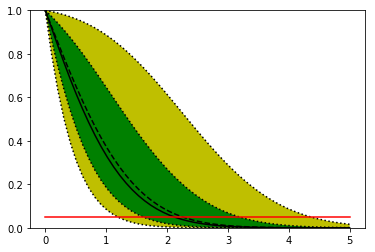

In [4]:
testmus = np.linspace(0,5)
results = [
    pyhf.utils.hypotest(mu, data + original.config.auxdata, 
                        original, original.config.suggested_init(), original.config.suggested_bounds(),
                       return_expected_set=True)
    for mu in testmus
]
plot_results(testmus,results,test_size = 0.05)

### Patching the likelihood to replace the BSM components

A nice thing about being able to specify the entire statistical model using the ubiquitous JSON format is that we can leverage a wide ecosystem of tools to manipulate JSON documents.

In particular we can use the [JSON-Patch](https://tools.ietf.org/html/rfc6902]) format (a proposed IETF standard) to replace the signal component of the statistical model with a new signal.

This new signal distribution could for example be the result of a third-party analysis implementation such as Rivet.

In [5]:
new_signal = [20.,10.]
patch = jsonpatch.JsonPatch([
    {'op': 'replace', 'path': '/channels/0/samples/0/data', 'value': new_signal},
])

In [6]:
recast = pyhf.Model(patch.apply(original.spec))
recast.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [20.0, 10.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
    {'name': 'background',
     'data': [50.0, 65.0],
     'modifiers': [{'name': 'uncorr_bkguncrt',
       'type': 'shapesys',
       'data': [5.0, 3.0]}]}]}]}

### The Recasted Result

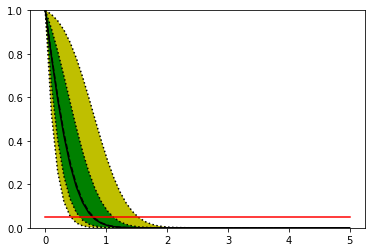

In [7]:
testmus = np.linspace(0,5)
results = [
    pyhf.utils.hypotest(mu, data + recast.config.auxdata, 
                     recast, recast.config.suggested_init(), recast.config.suggested_bounds(),
                    return_expected_set=True)
    for mu in testmus
]
plot_results(testmus,results,test_size = 0.05)